In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,KFold

In [2]:
dataset = pd.read_csv("sgemm_product.csv")
dataset.shape

(241600, 18)

In [3]:
dataset['AverageRun'] = dataset[['Run1 (ms)', 'Run2 (ms)', 'Run3 (ms)', 'Run4 (ms)']].mean(axis = 1)

In [4]:
dataset['AverageRun'].describe()

count    241600.000000
mean        217.571953
std         368.750161
min          13.317500
25%          40.667500
50%          69.790000
75%         228.387500
max        3341.507500
Name: AverageRun, dtype: float64

In [5]:
def scale_columns(dataframe):
    dfSubmean = dataframe - dataframe.mean()
    return dfSubmean / dataframe.std()

In [6]:
x = scale_columns(dataset[['MWG','NWG','KWG','MDIMC','NDIMC','MDIMA','NDIMB','KWI','VWM','VWN']])
x[['STRM','STRN','SA','SB']] = dataset[['STRM','STRN','SA','SB']]
x.head()

,MWG,NWG,KWG,MDIMC,NDIMC,MDIMA,NDIMB,KWI,VWM,VWN,STRM,STRN,SA,SB
0,-1.516754,-1.516754,-1.210995,-0.753892,-0.753892,-0.998052,-0.998052,-0.999998,-0.741447,-0.741447,0,0,0,0
1,-1.516754,-1.516754,-1.210995,-0.753892,-0.753892,-0.998052,-0.998052,-0.999998,-0.741447,-0.741447,0,0,0,1
2,-1.516754,-1.516754,-1.210995,-0.753892,-0.753892,-0.998052,-0.998052,-0.999998,-0.741447,-0.741447,0,0,1,0
3,-1.516754,-1.516754,-1.210995,-0.753892,-0.753892,-0.998052,-0.998052,-0.999998,-0.741447,-0.741447,0,0,1,1
4,-1.516754,-1.516754,-1.210995,-0.753892,-0.753892,-0.998052,-0.998052,-0.999998,-0.741447,-0.741447,0,1,0,0


In [7]:
dataset['AverageRun'].median()

69.79

In [8]:
def isGreaterThanMedian(x, median):
    if x > median:
        return 1
    return 0

In [9]:
median = dataset['AverageRun'].median()
target = dataset['AverageRun'].apply(isGreaterThanMedian, args = (median,))

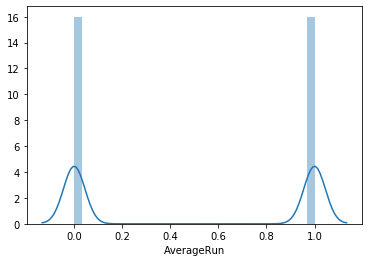

In [10]:
sns.distplot(target)

In [11]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, n_init=10, random_state=123)
kmeans.fit(x)
y_pred = kmeans.predict(x)
kmeansDf = pd.concat([x, pd.DataFrame(y_pred, columns = ['label'])], axis = 1)
kmeanAcc = (sum(target == y_pred)/y_pred.shape[0])*100
print("The accuracy of the Kmeans is {0:.2f}%".format(kmeanAcc))

The accuracy of the Kmeans is 37.49%


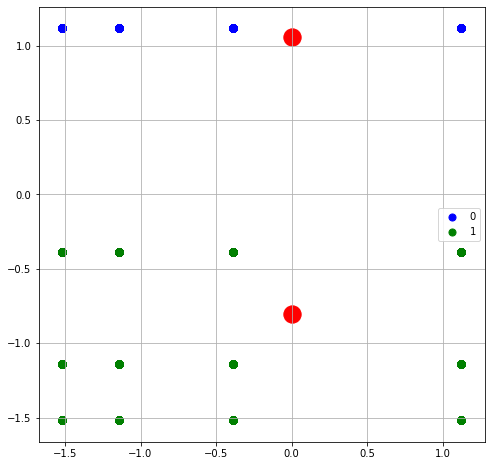

In [12]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
labels = [0,1]
colors = ['b', 'g']
for label, color in zip(labels,colors):
    indicesToKeep = kmeansDf['label'] == label
    ax.scatter(kmeansDf.loc[indicesToKeep, 'MWG']
               , kmeansDf.loc[indicesToKeep, 'NWG']
               , c = color
               , s = 50)
ax.legend(labels)
ax.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red')
ax.grid()

In [13]:
from sklearn.mixture import GaussianMixture
GMM = GaussianMixture(n_components = 2)
GMM.fit(x)
y_pred = GMM.predict(x)
GmmDf = pd.concat([x, pd.DataFrame(y_pred, columns = ['label'])], axis = 1)
EmAcc = (sum(target == y_pred)/y_pred.shape[0])*100
print("The accuracy of the EM is {0:.2f}%".format(EmAcc))

The accuracy of the EM is 48.94%


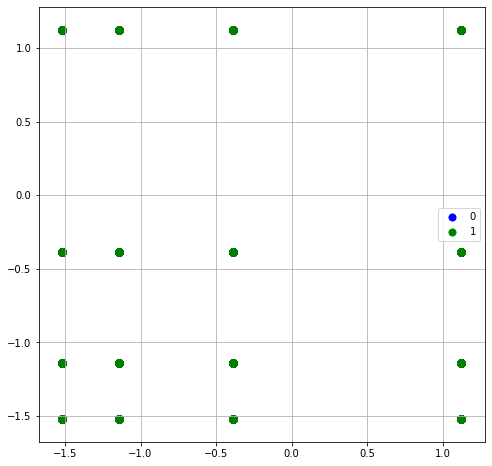

In [14]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
labels = [0,1]
colors = ['b', 'g']
for label, color in zip(labels,colors):
    indicesToKeep = GmmDf['label'] == label
    ax.scatter(GmmDf.loc[indicesToKeep, 'MWG']
               , GmmDf.loc[indicesToKeep, 'NWG']
               , c = color
               , s = 50)
ax.legend(labels)
ax.grid()

In [15]:
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeClassifier
featureSelector = SelectFromModel(estimator=DecisionTreeClassifier(), max_features = 2).fit(x,target)
selectedX = featureSelector.transform(x)
SelectedDF = pd.DataFrame(data = selectedX, columns = ['Selected Feature 1', 'Selected Feature 2'])
finalDf = pd.concat([SelectedDF, pd.DataFrame(target)], axis = 1)
finalDf.head()

,Selected Feature 1,Selected Feature 2,AverageRun
0,-1.516754,-1.516754,1
1,-1.516754,-1.516754,1
2,-1.516754,-1.516754,1
3,-1.516754,-1.516754,1
4,-1.516754,-1.516754,1


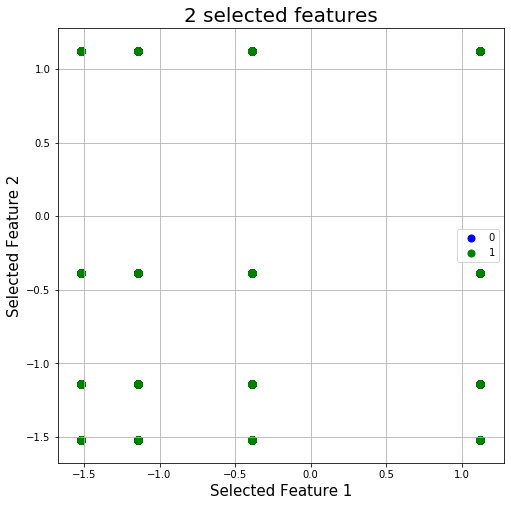

In [16]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Selected Feature 1', fontsize = 15)
ax.set_ylabel('Selected Feature 2', fontsize = 15)
ax.set_title('2 selected features', fontsize = 20)
labels = [0,1]
colors = ['b', 'g']
for label, color in zip(labels,colors):
    indicesToKeep = finalDf['AverageRun'] == label
    ax.scatter(finalDf.loc[indicesToKeep, 'Selected Feature 1']
               , finalDf.loc[indicesToKeep, 'Selected Feature 2']
               , c = color
               , s = 50)
ax.legend(labels)
ax.grid()

In [17]:
kmeans = KMeans(n_clusters=2, n_init=10, random_state=123)
kmeans.fit(selectedX)
y_pred = kmeans.predict(selectedX)
kmeansDf = pd.concat([SelectedDF, pd.DataFrame(y_pred, columns = ['label'])], axis = 1)
kmeanAcc = (sum(target == y_pred)/y_pred.shape[0])*100
print("The accuracy of the Kmeans with feature selection is {0:.2f}%".format(kmeanAcc))

The accuracy of the Kmeans with feature selection is 37.48%


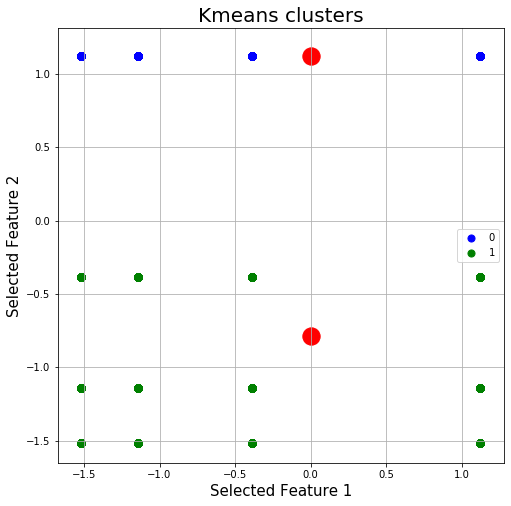

In [18]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Selected Feature 1', fontsize = 15)
ax.set_ylabel('Selected Feature 2', fontsize = 15)
ax.set_title('Kmeans clusters', fontsize = 20)
labels = [0,1]
colors = ['b', 'g']
for label, color in zip(labels,colors):
    indicesToKeep = kmeansDf['label'] == label
    ax.scatter(kmeansDf.loc[indicesToKeep, 'Selected Feature 1']
               , kmeansDf.loc[indicesToKeep, 'Selected Feature 2']
               , c = color
               , s = 50)
ax.legend(labels)
ax.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red')
ax.grid()

In [19]:
GMM = GaussianMixture(n_components = 2)
GMM.fit(selectedX)
y_pred = GMM.predict(selectedX)
GmmDf = pd.concat([SelectedDF, pd.DataFrame(y_pred, columns = ['label'])], axis = 1)
EmAcc = (sum(target == y_pred)/y_pred.shape[0])*100
print("The accuracy of the EM with feature selection is {0:.2f}%".format(EmAcc))

The accuracy of the EM with feature selection is 69.84%


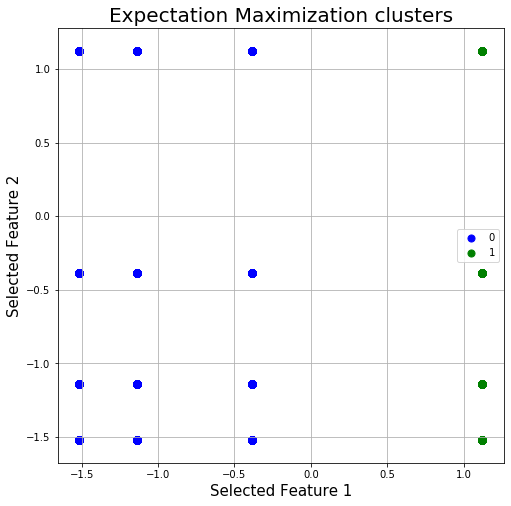

In [20]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Selected Feature 1', fontsize = 15)
ax.set_ylabel('Selected Feature 2', fontsize = 15)
ax.set_title('Expectation Maximization clusters', fontsize = 20)
labels = [0,1]
colors = ['b', 'g']
for label, color in zip(labels,colors):
    indicesToKeep = GmmDf['label'] == label
    ax.scatter(GmmDf.loc[indicesToKeep, 'Selected Feature 1']
               , GmmDf.loc[indicesToKeep, 'Selected Feature 2']
               , c = color
               , s = 50)
ax.legend(labels)
ax.grid()

In [21]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

In [22]:
finalDf = pd.concat([principalDf, pd.DataFrame(target)], axis = 1)
finalDf.head()

,principal component 1,principal component 2,AverageRun
0,0.898193,-0.000520,1
1,0.898751,-0.000235,1
2,0.897971,-0.000019,1
3,0.898529,0.000267,1
4,0.898247,-0.000644,1


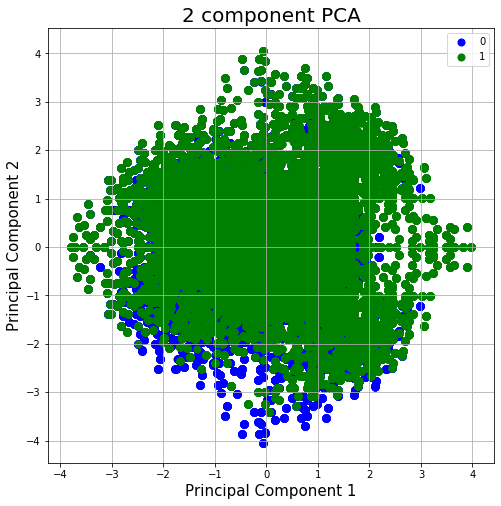

In [23]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
labels = [0,1]
colors = ['b', 'g']
for label, color in zip(labels,colors):
    indicesToKeep = finalDf['AverageRun'] == label
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(labels)
ax.grid()

In [24]:
kmeans = KMeans(n_clusters=2, n_init=10, random_state=123)
kmeans.fit(principalDf)
y_pred = kmeans.predict(principalDf)
kmeansDf = pd.concat([principalDf, pd.DataFrame(y_pred, columns = ['label'])], axis = 1)
kmeanAcc = (sum(target == y_pred)/y_pred.shape[0])*100
print("The accuracy of the Kmeans with PCA is {0:.2f}%".format(kmeanAcc))

The accuracy of the Kmeans with PCA is 41.55%


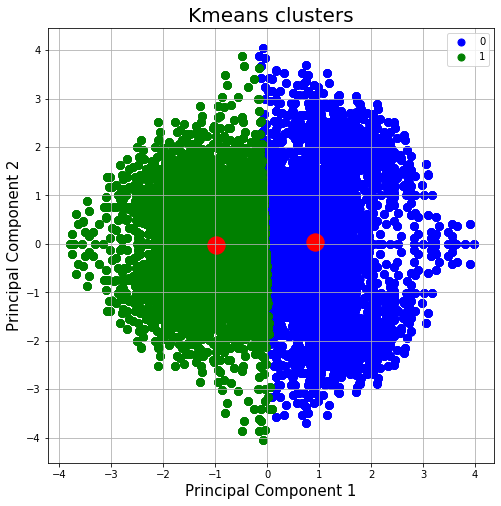

In [25]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('Kmeans clusters', fontsize = 20)
labels = [0,1]
colors = ['b', 'g']
for label, color in zip(labels,colors):
    indicesToKeep = kmeansDf['label'] == label
    ax.scatter(kmeansDf.loc[indicesToKeep, 'principal component 1']
               , kmeansDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(labels)
ax.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red')
ax.grid()

In [26]:
GMM = GaussianMixture(n_components = 2)
GMM.fit(principalDf)
y_pred = GMM.predict(principalDf)
GmmDf = pd.concat([principalDf, pd.DataFrame(y_pred, columns = ['label'])], axis = 1)
EmAcc = (sum(target == y_pred)/y_pred.shape[0])*100
print("The accuracy of the EM with PCA is {0:.2f}%".format(EmAcc))

The accuracy of the EM with PCA is 50.57%


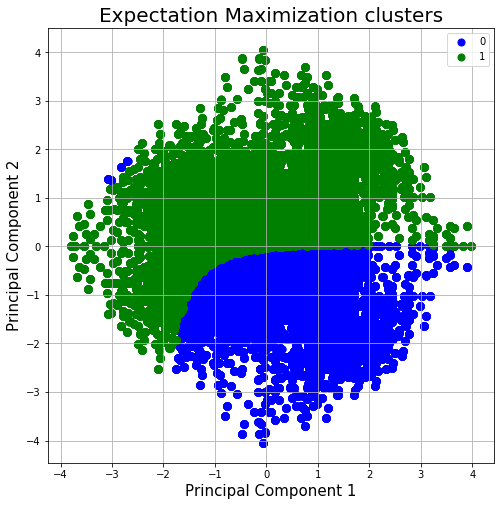

In [27]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('Expectation Maximization clusters', fontsize = 20)
labels = [0,1]
colors = ['b', 'g']
for label, color in zip(labels,colors):
    indicesToKeep = GmmDf['label'] == label
    ax.scatter(GmmDf.loc[indicesToKeep, 'principal component 1']
               , GmmDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(labels)
ax.grid()

In [28]:
from sklearn.decomposition import FastICA
ica = FastICA(n_components=2)
principalComponents = ica.fit_transform(x)
icaDf = pd.DataFrame(data = principalComponents, columns = ['Independent component 1', 'Independent component 2'])
finalDf = pd.concat([icaDf, pd.DataFrame(target)], axis = 1)
finalDf.head()

,Independent component 1,Independent component 2,AverageRun
0,0.001082,-0.001083,1
1,0.001082,-0.001083,1
2,0.001082,-0.001083,1
3,0.001082,-0.001083,1
4,0.001082,-0.001083,1


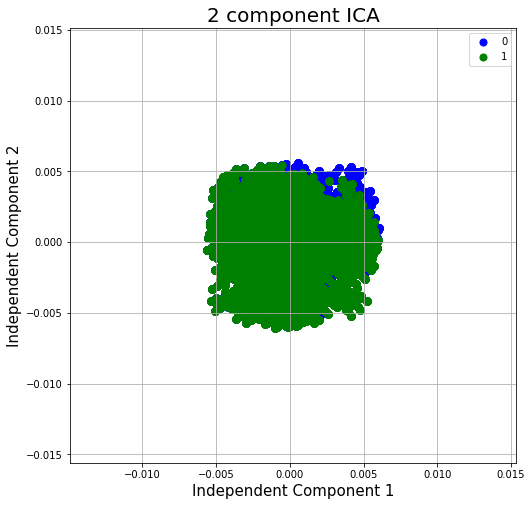

In [29]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Independent Component 1', fontsize = 15)
ax.set_ylabel('Independent Component 2', fontsize = 15)
ax.set_title('2 component ICA', fontsize = 20)
labels = [0,1]
colors = ['b', 'g']
for label, color in zip(labels,colors):
    indicesToKeep = finalDf['AverageRun'] == label
    ax.scatter(finalDf.loc[indicesToKeep, 'Independent component 1']
               , finalDf.loc[indicesToKeep, 'Independent component 2']
               , c = color
               , s = 50)
ax.legend(labels)
ax.grid()

In [30]:
kmeans = KMeans(n_clusters=2, n_init=10, random_state=123)
kmeans.fit(icaDf)
y_pred = kmeans.predict(icaDf)
kmeansDf = pd.concat([icaDf, pd.DataFrame(y_pred, columns = ['label'])], axis = 1)
kmeanAcc = (sum(target == y_pred)/y_pred.shape[0])*100
print("The accuracy of the Kmeans with ICA is {0:.2f}%".format(kmeanAcc))

The accuracy of the Kmeans with ICA is 41.54%


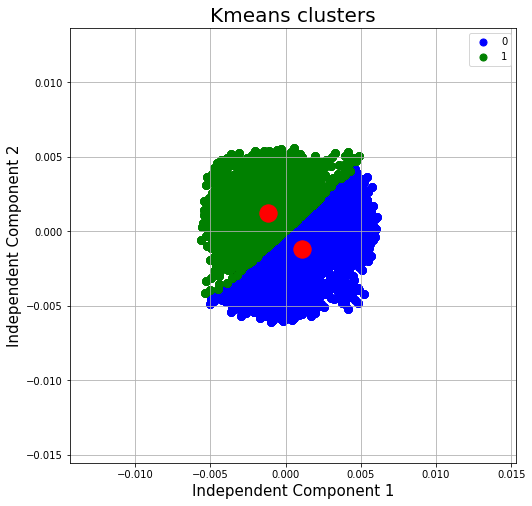

In [31]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Independent Component 1', fontsize = 15)
ax.set_ylabel('Independent Component 2', fontsize = 15)
ax.set_title('Kmeans clusters', fontsize = 20)
labels = [0,1]
colors = ['b', 'g']
for label, color in zip(labels,colors):
    indicesToKeep = kmeansDf['label'] == label
    ax.scatter(kmeansDf.loc[indicesToKeep, 'Independent component 1']
               , kmeansDf.loc[indicesToKeep, 'Independent component 2']
               , c = color
               , s = 50)
ax.legend(labels)
ax.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red')
ax.grid()

In [32]:
GMM = GaussianMixture(n_components = 2)
GMM.fit(icaDf)
y_pred = GMM.predict(icaDf)
GmmDf = pd.concat([icaDf, pd.DataFrame(y_pred, columns = ['label'])], axis = 1)
EmAcc = (sum(target == y_pred)/y_pred.shape[0])*100
print("The accuracy of the EM with ICA is {0:.2f}%".format(EmAcc))

The accuracy of the EM with ICA is 42.35%


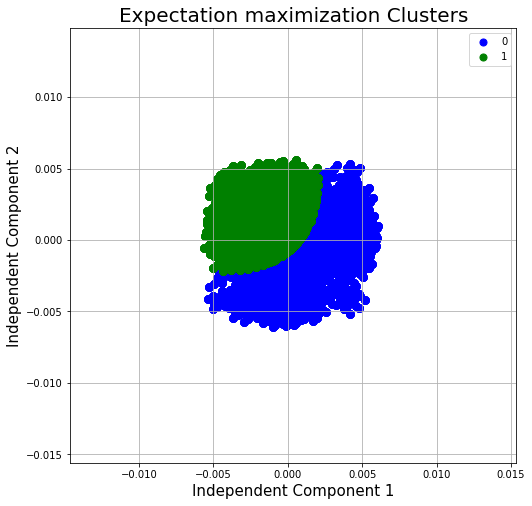

In [33]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Independent Component 1', fontsize = 15)
ax.set_ylabel('Independent Component 2', fontsize = 15)
ax.set_title('Expectation maximization Clusters', fontsize = 20)
labels = [0,1]
colors = ['b', 'g']
for label, color in zip(labels,colors):
    indicesToKeep = GmmDf['label'] == label
    ax.scatter(GmmDf.loc[indicesToKeep, 'Independent component 1']
               , GmmDf.loc[indicesToKeep, 'Independent component 2']
               , c = color
               , s = 50)
ax.legend(labels)
ax.grid()

In [34]:
from sklearn.random_projection import GaussianRandomProjection
rca = GaussianRandomProjection(n_components=2)
principalComponents = rca.fit_transform(x)
rcaDf = pd.DataFrame(data = principalComponents, columns = ['Random component 1', 'Random component 2'])
finalDf = pd.concat([rcaDf, pd.DataFrame(target)], axis = 1)
finalDf.head()

,Random component 1,Random component 2,AverageRun
0,2.996253,-1.558473,1
1,2.347052,-2.014081,1
2,2.278080,-0.900884,1
3,1.628879,-1.356493,1
4,3.844914,-1.768306,1


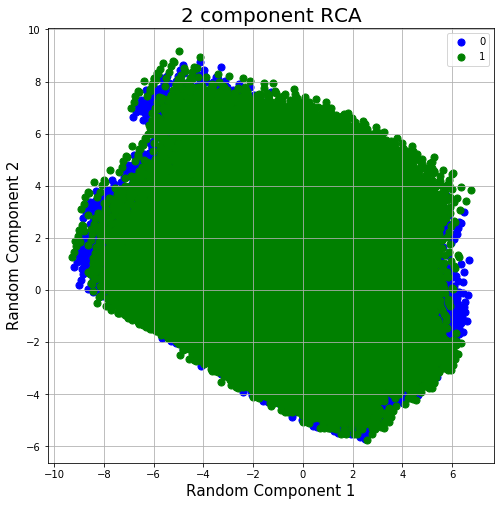

In [35]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Random Component 1', fontsize = 15)
ax.set_ylabel('Random Component 2', fontsize = 15)
ax.set_title('2 component RCA', fontsize = 20)
labels = [0,1]
colors = ['b', 'g']
for label, color in zip(labels,colors):
    indicesToKeep = finalDf['AverageRun'] == label
    ax.scatter(finalDf.loc[indicesToKeep, 'Random component 1']
               , finalDf.loc[indicesToKeep, 'Random component 2']
               , c = color
               , s = 50)
ax.legend(labels)
ax.grid()

In [36]:
kmeans = KMeans(n_clusters=2, n_init=10, random_state=123)
kmeans.fit(rcaDf)
y_pred = kmeans.predict(rcaDf)
kmeansDf = pd.concat([rcaDf, pd.DataFrame(y_pred, columns = ['label'])], axis = 1)
kmeanAcc = (sum(target == y_pred)/y_pred.shape[0])*100
print("The accuracy of the Kmeans with RCA is {0:.2f}%".format(kmeanAcc))

The accuracy of the Kmeans with RCA is 51.89%


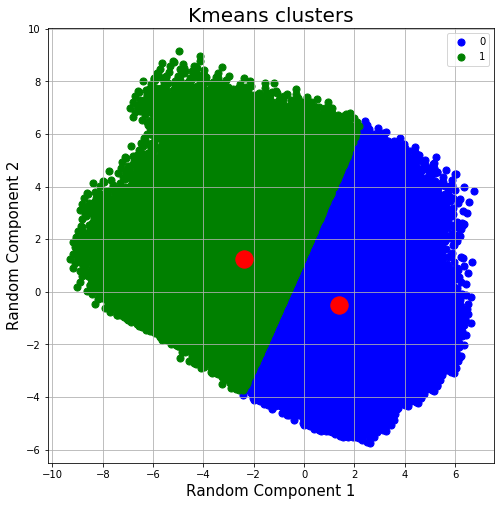

In [37]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Random Component 1', fontsize = 15)
ax.set_ylabel('Random Component 2', fontsize = 15)
ax.set_title('Kmeans clusters', fontsize = 20)
labels = [0,1]
colors = ['b', 'g']
for label, color in zip(labels,colors):
    indicesToKeep = kmeansDf['label'] == label
    ax.scatter(kmeansDf.loc[indicesToKeep, 'Random component 1']
               , kmeansDf.loc[indicesToKeep, 'Random component 2']
               , c = color
               , s = 50)
ax.legend(labels)
ax.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red')
ax.grid()

In [38]:
GMM = GaussianMixture(n_components = 2)
GMM.fit(rcaDf)
y_pred = GMM.predict(rcaDf)
GmmDf = pd.concat([rcaDf, pd.DataFrame(y_pred, columns = ['label'])], axis = 1)
EmAcc = (sum(target == y_pred)/y_pred.shape[0])*100
print("The accuracy of the EM with RCA is {0:.2f}%".format(EmAcc))

The accuracy of the EM with RCA is 54.02%


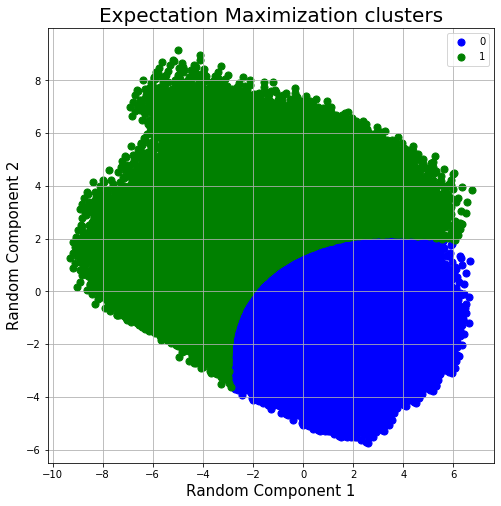

In [39]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Random Component 1', fontsize = 15)
ax.set_ylabel('Random Component 2', fontsize = 15)
ax.set_title('Expectation Maximization clusters', fontsize = 20)
labels = [0,1]
colors = ['b', 'g']
for label, color in zip(labels,colors):
    indicesToKeep = GmmDf['label'] == label
    ax.scatter(GmmDf.loc[indicesToKeep, 'Random component 1']
               , GmmDf.loc[indicesToKeep, 'Random component 2']
               , c = color
               , s = 50)
ax.legend(labels)
ax.grid()

In [40]:
from keras.models import Sequential
from keras.layers import Dense, Activation,Flatten
model = Sequential()
model.add(Dense(128, activation='sigmoid'))
model.add(Dense(2, activation='sigmoid'))
model.compile(optimizer='SGD',
              loss='binary_crossentropy',
              metrics=['acc'])

Using TensorFlow backend.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [41]:
selectedArray = np.array(SelectedDF)
print(selectedArray.shape)
from keras.utils import to_categorical
y = np.array(target)
y = to_categorical(y)
print(y.shape)

(241600, 2)
(241600, 2)


In [42]:
X_train, X_test, y_train, y_test = train_test_split(selectedArray, y, test_size= 0.1, random_state=123)
val_acc = []
kf = KFold(n_splits=5)
for train_index, val_index in kf.split(X_train):
    model.fit(X_train[train_index], y_train[train_index],epochs=5,batch_size=128)
    val_acc.append(model.evaluate(X_train[val_index],y_train[val_index],batch_size=128)[1])
selAcc = sum(val_acc)/len(val_acc)*100
print("The accuracy of the neural net with feature selection is {0:.2f}%".format(selAcc))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/5
173952/173952 [==============================] - 2s 13us/step - loss: 0.6617 - acc: 0.6957
Epoch 2/5
173952/173952 [==============================] - 2s 13us/step - loss: 0.6076 - acc: 0.7255
Epoch 3/5
173952/173952 [==============================] - 2s 12us/step - loss: 0.5816 - acc: 0.7255
Epoch 4/5
173952/173952 [==============================] - 2s 12us/step - loss: 0.5730 - acc: 0.7255
Epoch 5/5
43488/43488 [==============================] - 0s 9us/step
Epoch 1/5
173952/173952 [==============================] - 3s 15us/step - loss: 0.5711 - acc: 0.7248
Epoch 2/5
173952/173952 [==============================] - 3s 16us/step - loss: 0.5710 - acc: 0.7248
Epoch 3/5
173952/173952 [==============================] - 2s 14us/step - loss: 0.5709 - acc: 0.7248
Epoch 4/5
173952/173952 [==============================] - 2s 14us/step - loss: 0.5708 - acc: 0.7248
Epoch 5/5
43488/43488 [=====

In [43]:
pcaArray = np.array(principalDf)
print(pcaArray.shape)

(241600, 2)


In [44]:
X_train, X_test, y_train, y_test = train_test_split(pcaArray, y, test_size= 0.1, random_state=123)
val_acc = []
kf = KFold(n_splits=5)
for train_index, val_index in kf.split(X_train):
    model.fit(X_train[train_index], y_train[train_index],epochs=5,batch_size=128)
    val_acc.append(model.evaluate(X_train[val_index],y_train[val_index],batch_size=128)[1])
pcaAcc = sum(val_acc)/len(val_acc)*100
print("The accuracy of the neural net with PCA is {0:.2f}%".format(pcaAcc))

Epoch 1/5
173952/173952 [==============================] - 2s 13us/step - loss: 0.6891 - acc: 0.5864: 0s - loss: 0.6930 - a
Epoch 2/5
173952/173952 [==============================] - 2s 13us/step - loss: 0.6674 - acc: 0.5870
Epoch 3/5
173952/173952 [==============================] - 2s 13us/step - loss: 0.6637 - acc: 0.5869: 1s 
Epoch 4/5
173952/173952 [==============================] - 2s 13us/step - loss: 0.6630 - acc: 0.5876
Epoch 5/5
43488/43488 [==============================] - 0s 8us/step
Epoch 1/5
173952/173952 [==============================] - 3s 15us/step - loss: 0.6631 - acc: 0.5871
Epoch 2/5
173952/173952 [==============================] - 2s 13us/step - loss: 0.6630 - acc: 0.5871
Epoch 3/5
173952/173952 [==============================] - 2s 13us/step - loss: 0.6630 - acc: 0.5874:
Epoch 4/5
173952/173952 [==============================] - 2s 13us/step - loss: 0.6630 - acc: 0.5877
Epoch 5/5
43488/43488 [==============================] - 0s 7us/step
Epoch 1/5
173952/173952 [

In [45]:
icaArray = np.array(icaDf)
print(icaArray.shape)

(241600, 2)


In [46]:
X_train, X_test, y_train, y_test = train_test_split(icaArray, y, test_size= 0.1, random_state=123)
val_acc = []
kf = KFold(n_splits=5)
for train_index, val_index in kf.split(X_train):
    model.fit(X_train[train_index], y_train[train_index],epochs=5,batch_size=128)
    val_acc.append(model.evaluate(X_train[val_index],y_train[val_index],batch_size=128)[1])
icaAcc = sum(val_acc)/len(val_acc)*100
print("The accuracy of the neural net with ICA is {0:.2f}%".format(icaAcc))

Epoch 1/5
173952/173952 [==============================] - 3s 15us/step - loss: 0.6932 - acc: 0.5004
Epoch 2/5
173952/173952 [==============================] - 2s 14us/step - loss: 0.6932 - acc: 0.5012
Epoch 3/5
173952/173952 [==============================] - 3s 15us/step - loss: 0.6932 - acc: 0.5017
Epoch 4/5
173952/173952 [==============================] - 2s 14us/step - loss: 0.6932 - acc: 0.4997
Epoch 5/5
43488/43488 [==============================] - 0s 7us/step
Epoch 1/5
173952/173952 [==============================] - 2s 13us/step - loss: 0.6932 - acc: 0.4997
Epoch 2/5
173952/173952 [==============================] - 2s 13us/step - loss: 0.6932 - acc: 0.4997
Epoch 3/5
173952/173952 [==============================] - 3s 16us/step - loss: 0.6933 - acc: 0.4975
Epoch 4/5
173952/173952 [==============================] - 2s 14us/step - loss: 0.6932 - acc: 0.5002
Epoch 5/5
43488/43488 [==============================] - 0s 8us/step
Epoch 1/5
173952/173952 [=============================

In [47]:
rcaArray = np.array(rcaDf)
print(rcaArray.shape)

(241600, 2)


In [48]:
X_train, X_test, y_train, y_test = train_test_split(rcaArray, y, test_size= 0.1, random_state=123)
val_acc = []
kf = KFold(n_splits=5)
for train_index, val_index in kf.split(X_train):
    model.fit(X_train[train_index], y_train[train_index],epochs=5,batch_size=128)
    val_acc.append(model.evaluate(X_train[val_index],y_train[val_index],batch_size=128)[1])
rcaAcc = sum(val_acc)/len(val_acc)*100
print("The accuracy of the neural net with RCA is {0:.2f}%".format(rcaAcc))

Epoch 1/5
173952/173952 [==============================] - 3s 16us/step - loss: 0.7007 - acc: 0.5291
Epoch 2/5
173952/173952 [==============================] - 3s 15us/step - loss: 0.6830 - acc: 0.5401
Epoch 3/5
173952/173952 [==============================] - 2s 14us/step - loss: 0.6828 - acc: 0.5422
Epoch 4/5
173952/173952 [==============================] - 2s 13us/step - loss: 0.6827 - acc: 0.5429
Epoch 5/5
43488/43488 [==============================] - 0s 8us/step
Epoch 1/5
173952/173952 [==============================] - 2s 13us/step - loss: 0.6829 - acc: 0.5430
Epoch 2/5
173952/173952 [==============================] - 3s 15us/step - loss: 0.6829 - acc: 0.5425
Epoch 3/5
173952/173952 [==============================] - 2s 14us/step - loss: 0.6828 - acc: 0.5427
Epoch 4/5
173952/173952 [==============================] - 2s 13us/step - loss: 0.6828 - acc: 0.5424
Epoch 5/5
43488/43488 [==============================] - 0s 7us/step
Epoch 1/5
173952/173952 [=============================

<BarContainer object of 4 artists>

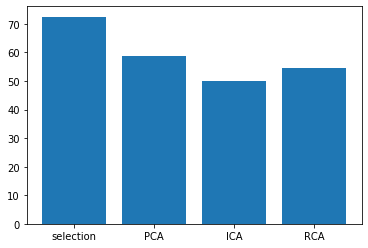

In [49]:
performance = [selAcc, pcaAcc, icaAcc, rcaAcc]
transType = ['selection', 'PCA', 'ICA', 'RCA']
plt.bar(transType, performance, align='center')

In [50]:
kmeans = KMeans(n_clusters=2, n_init=10, random_state=123)
kmeans.fit(x)
kmeanOut = kmeans.predict(x)
GMM = GaussianMixture(n_components = 2)
GMM.fit(x)
emOut = GMM.predict(x)

In [51]:
inputArray = np.column_stack((kmeanOut, emOut))
inputArray.shape

(241600, 2)

In [52]:
X_train, X_test, y_train, y_test = train_test_split(inputArray, y, test_size= 0.1, random_state=123)
val_acc = []
kf = KFold(n_splits=5)
for train_index, val_index in kf.split(X_train):
    model.fit(X_train[train_index], y_train[train_index],epochs=5,batch_size=128)
    val_acc.append(model.evaluate(X_train[val_index],y_train[val_index],batch_size=128)[1])
kmEmAcc = sum(val_acc)/len(val_acc)*100
print("The accuracy of the neural net with results of kmeans and EM is {0:.2f}%".format(kmEmAcc))

Epoch 1/5
173952/173952 [==============================] - 2s 14us/step - loss: 0.6981 - acc: 0.4289
Epoch 2/5
173952/173952 [==============================] - 2s 11us/step - loss: 0.6741 - acc: 0.6557
Epoch 3/5
173952/173952 [==============================] - 2s 11us/step - loss: 0.6517 - acc: 0.6831
Epoch 4/5
173952/173952 [==============================] - 3s 15us/step - loss: 0.6294 - acc: 0.6920
Epoch 5/5
43488/43488 [==============================] - 0s 8us/step
Epoch 1/5
173952/173952 [==============================] - 3s 17us/step - loss: 0.5938 - acc: 0.6999
Epoch 2/5
173952/173952 [==============================] - 3s 16us/step - loss: 0.5830 - acc: 0.7002
Epoch 3/5
173952/173952 [==============================] - 3s 15us/step - loss: 0.5764 - acc: 0.7002
Epoch 4/5
173952/173952 [==============================] - 5s 28us/step - loss: 0.5726 - acc: 0.7002
Epoch 5/5
43488/43488 [==============================] - 0s 9us/step
Epoch 1/5
173952/173952 [=============================